# Candlehoarder charts and examples

This notebook contains code that is used for use with the Candlehoarder program. Candlehoarder is a collection of scripts, markdown pages and charts that help with the decision making process for digital assets (read Bitcoin and other cryptocurrencies).

## Install the necessary external modules

In [2]:
!pip3 install pandas_ta

  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218922 sha256=cf88ee21773319f382afbb3d552c6cf72d3ff612a628a270a98a9aa996af6617
  Stored in directory: c:\users\bas\appdata\local\pip\cache\wheels\1e\5c\47\759b32beb377aee150eb4c1f1b2b7635032cc19ea09ce076fd
Successfully built pandas-ta


In [4]:
!pip install TA-Lib

  Using cached TA-Lib-0.4.24.tar.gz (269 kB)
  Created wheel for TA-Lib: filename=TA_Lib-0.4.24-cp39-cp39-win_amd64.whl size=511805 sha256=e9198e4b29cf86a532b64475ba51160ce0267e7b18d4c3a2c1ee66948459feb9
  Stored in directory: c:\users\bas\appdata\local\pip\cache\wheels\f6\c1\21\f37f7b0b19f995f2820f33bc6af33bf972900de1ebb7de9868
Successfully built TA-Lib


In [6]:
!pip install mplfinance

  Using cached mplfinance-0.12.9b1-py3-none-any.whl (70 kB)


## Importing libraries and creating the data connection

In [7]:
# Load libraries
import pandas as pd
import pandas_ta as pta
import talib.abstract as ta
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from datetime import datetime
import numpy as np
import mplfinance as mpf
import sqlite3

In [8]:
# Connect to database, create a dataframe from last 999 rows (Descending) and close the database connection
conn = sqlite3.connect("file:./data/ETHUSDT.db?mode=ro", uri=True)
df = pd.read_sql_query("SELECT * FROM (SELECT openTime,open,high,low,close,volume,dow,color,humandate FROM _1d ORDER BY openTime DESC LIMIT 999) sub ORDER BY openTime ASC", conn)
conn.close()

# Create human readable time
df['openTime']=(pd.to_datetime(df['openTime'],unit='s'))

# Show the last 10 entries of the dataframe
df.tail(10)

,openTime,open,high,low,close,volume,dow,color,humandate
989,2022-06-03,1834.09,1843.91,1737.00,1775.12,7.412825e+05,Friday,Red,20220603
990,2022-06-04,1775.13,1816.00,1748.43,1804.58,3.882795e+05,Saturday,Green,20220604
991,2022-06-05,1804.58,1830.17,1773.05,1806.23,3.719745e+05,Sunday,Green,20220605
992,2022-06-06,1806.22,1920.00,1804.35,1859.84,8.042504e+05,Monday,Green,20220606
993,2022-06-07,1859.84,1874.98,1725.13,1813.33,1.397598e+06,Tuesday,Red,20220607
994,2022-06-08,1813.33,1838.77,1765.28,1791.88,9.415101e+05,Wednesday,Red,20220608
995,2022-06-09,1791.88,1833.00,1777.33,1788.81,5.353110e+05,Thursday,Red,20220609
996,2022-06-10,1788.80,1804.32,1655.93,1662.91,9.550358e+05,Friday,Red,20220610
997,2022-06-11,1662.91,1682.21,1496.74,1532.89,1.220325e+06,Saturday,Red,20220611
998,2022-06-12,1532.89,1547.00,1423.00,1434.84,1.563225e+06,Sunday,Red,20220612


As you can see, the dataframe not only has the OHLCV values, but also day of week, candle color and a human date. These columns were created when the database originally was created and updated every time the candlehoarder fetches data. So, this is all the available data we have for creating investment decision making charts.

## Strategy charts

These are the charts that will be created. Each chart creating function will be added to the Candlehoarder's "/modules/strategy.py" file.

### Mayer multiple

Creating Mayer multiple plot for ETHUSDT on 1 Day...


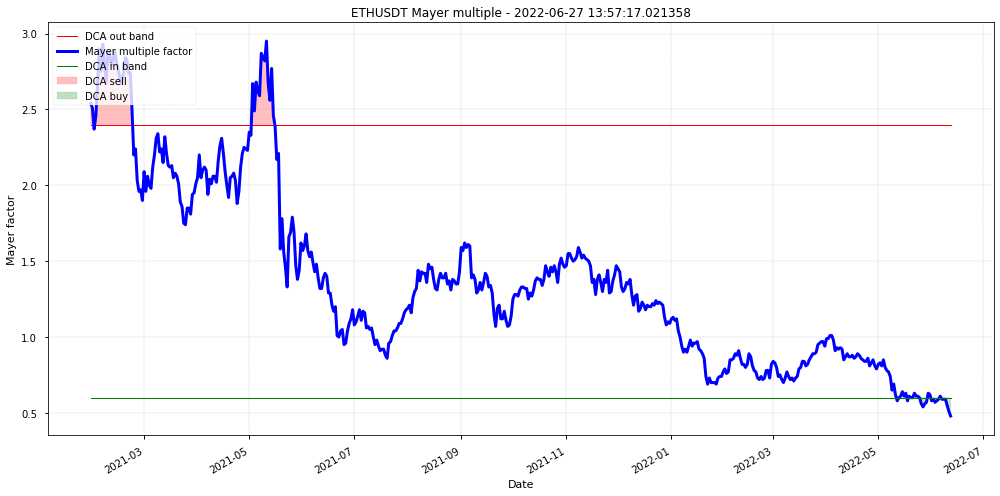

In [9]:
def mayer_multiple(df):
    """_summary_
    Introduced by Trace Mayer as a way to gauge the current price of Bitcoin against its long range 
    historical price movements (200 day moving average), the Mayer Multiple highlights when Bitcoin 
    is overbought or oversold in the context of longer time frames.
    Mayer Multiple Formula:

    Bitcoin market price / 200 day MA value = Mayer Multiple
    Any multiple above the 2.4 threshold has historically shown to signify the beginning of a 
    speculative bubble, which is significant because all bubbles eventually burst, causing a rapid 
    depreciation. 
    The Mayer Multiple has never fallen below 0.237, the value that marked the bottom of bitcoin’s 
    first significant bear market in 2011.
    Any value above 2.4 means that your assets should be (DCA) sold because of bullish overextension 
    to the SMA200 and FOMO. Here you lock in profits. Any value below 0.7 means that assets could be 
    (DCA) bought because of bearish overextention and FUD in the markets. Here you buy when blood runs
    though the streets.

    Args:
        df (_type_): dataframe
    """
    # These variables normally come from outer sources via the function.
    symbol = "ETHUSDT"
    time_frame = "1 Day"
    ct = str(datetime.now())
    
    if len(df) > 201:
        print(f"Creating Mayer multiple plot for {symbol} on {time_frame}...")

        # Determine lookback period.
        days = 500
        upper_band_factor = 2.4
        lower_band_factor = 0.6
        
        # Create indicators:
        # SMA 200
        df['sma200'] = (pta.sma(df["close"], length=200)).round(2)
        # Mayer multiple with upper and lower band
        df["mayer"] = (df["close"] / df['sma200']).round(2)
        df["upper_band_factor"] = upper_band_factor
        df["lower_band_factor"] = lower_band_factor

        # Plot output to graphs for wiki.
        plt.style.use('seaborn-notebook')
        plt.figure(figsize=(14, 7))
        plt.grid(linestyle='--', linewidth=0.3)

        dates = df['openTime'].tail(days)
        upper_band = df["upper_band_factor"].tail(days)
        lower_band = df["lower_band_factor"].tail(days)
        mayer = df['mayer'].tail(days)

        # Adding lines.
        plt.plot(dates, upper_band, label='DCA out band', linewidth=1, color='red')
        plt.plot(dates, mayer, label='Mayer multiple factor', linewidth=3, color='blue')
        plt.plot(dates, lower_band, label='DCA in band', linewidth=1, color='green')

        plt.gcf().autofmt_xdate()

        # Fill when mayer goes above/below bands.
        plt.fill_between(dates, upper_band, mayer,where=(mayer > upper_band), color='red', alpha=0.25,label='DCA sell')
        plt.fill_between(dates, lower_band, mayer,where=(mayer < lower_band), color='green', alpha=0.25,label='DCA buy')
        
        plt.title(symbol + ' Mayer multiple - ' + ct)
        plt.xlabel('Date')
        plt.ylabel('Mayer factor')
        plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()          # Show plot for visual check. Can be commented out when using in background script.

        # Save plot to external file section:
        # plt.savefig(f'{dir}mdwiki/plots/mayer_multiple-{symbol}-{time_frame}.png')
        plt.cla()         # Clear plot
        plt.close()       # Close plot
        
    elif len(df) < 201:
        print(symbol + ' has not enough data to create Mayer multiple chart')

mayer_multiple(df)

 ### The Gutter acculumation channel

Creating Gutter accumulation plot for ETHUSDT on 1 Day...


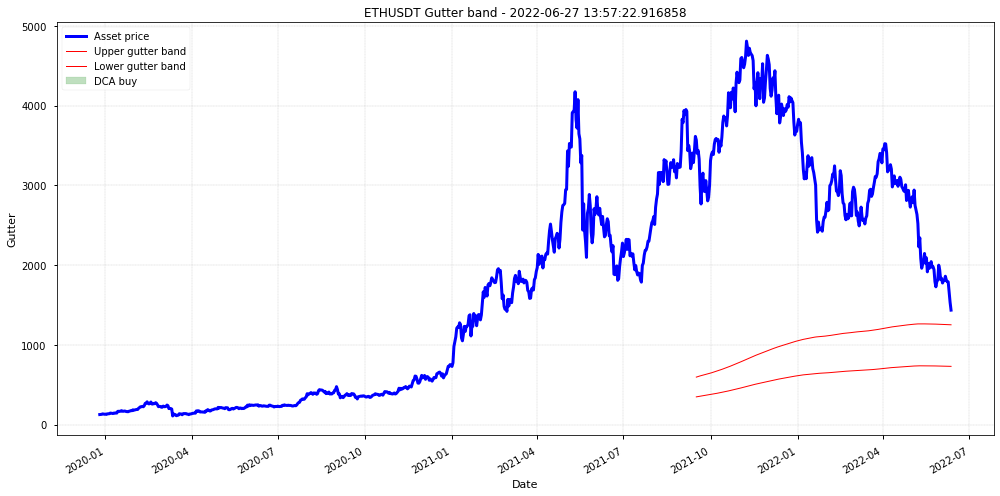

In [10]:
def gutter_accumulation_channel(df):
    """_summary_
    The [Gutter accumulation channel](https://twitter.com/TheRealPlanC/status/1540116703614484481?ref_src=twsrc%5Etfw) 
    is a indicator from Twitter's 'Plan C'. It consists of a channel made of the 2 year EMA (730 days). The upper 
    boundary of the channel is 60% of this 2 year ema and a lower boundary of 35% of this ema. Every time the price of 
    an asset is in this 60%/35% band, then it signals good conditions to DCA into assets before the next bull run.

    Args:
        df (_type_): dataframe
    """
    # These variables normally come from outer sources via the function.
    symbol = "ETHUSDT"
    time_frame = "1 Day"
    ct = str(datetime.now())
    
    if len(df) > 801:
        print(f"Creating Gutter accumulation plot for {symbol} on {time_frame}...")

        # Determine lookback period.
        days = 900
        upper_lower_band_factor = 0.6
        lower_lower_band_factor = 0.35

        # Create indicators:
        # Gutter band (determine )
        df['2yema200'] = (pta.ema(df["close"], length=730)).round(2)
        df["gutter_upper_band"] = upper_lower_band_factor * df['2yema200']
        df["gutter_lower_band"] = lower_lower_band_factor * df['2yema200']

        # Plot output to graphs for wiki.
        plt.style.use('seaborn-notebook')
        plt.figure(figsize=(14, 7))
        plt.grid(linestyle='--', linewidth=0.3)

        dates = df['openTime'].tail(days)
        close = df["close"].tail(days)
        ema_2_year = df['2yema200'].tail(days)
        upper_lower_band = df["gutter_upper_band"].tail(days)
        lower_lower_band = df["gutter_lower_band"].tail(days)
        
        # Adding lines.
        plt.plot(dates, close, label='Asset price', linewidth=3, color='blue')
        plt.plot(dates, upper_lower_band, label='Upper gutter band', linewidth=1, color='red')
        plt.plot(dates, lower_lower_band, label='Lower gutter band', linewidth=1, color='red')

        plt.gcf().autofmt_xdate()

        # Fill when guter goes between bands.
        # plt.fill_between(dates, upper_lower_band, ema_2_year,where=(gutter > upper_lower_band), color='red', alpha=0.25,label='DCA sell')
        plt.fill_between(dates, lower_lower_band, close, where=(close < upper_lower_band), color='green', alpha=0.25,label='DCA buy')
        
        plt.title(symbol + ' Gutter band - ' + ct)
        plt.xlabel('Date')
        plt.ylabel('Gutter')
        plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()          # Show plot for visual check. Can be commented out when using in background script.

        # Save plot to external file section:
        # plt.savefig(f'{dir}mdwiki/plots/gutter_band-{symbol}-{time_frame}.png')
        plt.cla()         # Clear plot
        plt.close()       # Close plot
        
    elif len(df) < 801:
        print(symbol + ' has not enough data to create Mayer multiple chart')

gutter_accumulation_channel(df)

### Bull / Bear support band

Creating Bull support band plot for ETHUSDT on 1 Day...


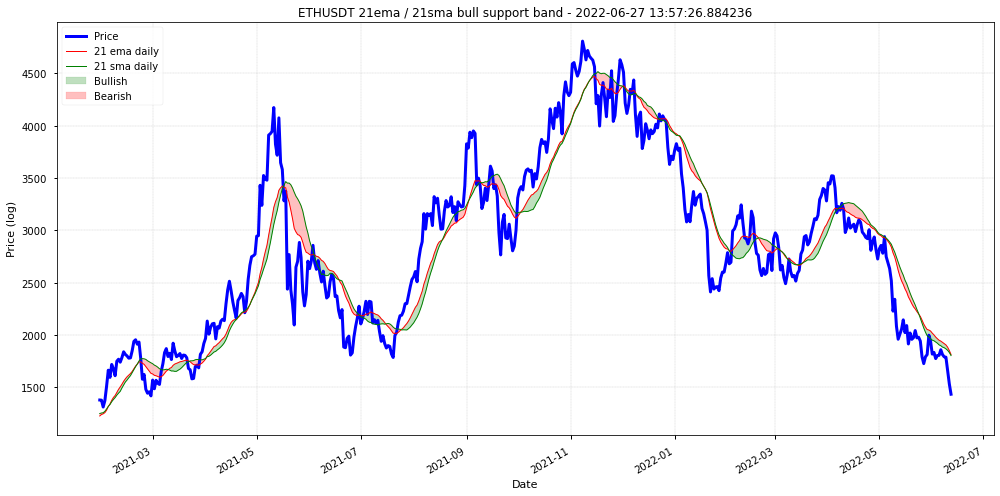

In [11]:
def bull_support_band(df):
    """_summary_
    The bull support band is a band consisting of the 21 sma and 21 ema. When the close price is above both the
    sma and ema, and ema is above sma, then a bullish market can be formed. As long as the price is below or around
    the band, there is no clear direction.

    Args:
        df (_type_): dataframe
    """

    # These variables normally come from outer sources via the function.
    # def bull_support_band(symbol, time_frame, df):
    symbol = "ETHUSDT"
    time_frame = "1 Day"
    ct = str(datetime.now())

    print(f"Creating Bull support band plot for {symbol} on {time_frame}...")

    # Determine lookback period.
    days = 500

    # Create colums in dataframe for plotting.
    df['sma21'] = pta.sma(df["close"], length=21)
    df['ema21'] = pta.ema(df["close"], length=21)

    # Plot output to graphs for wiki.
    plt.style.use('seaborn-notebook')
    plt.figure(figsize=(14, 7))
    plt.grid(linestyle='--', linewidth=0.3)

    # df.sort_values(df['Date'], inplace=True)

    dates = df['openTime'].tail(days)
    price = df['close'].tail(days)
    sma21 = df['sma21'].tail(days)
    ema21 = df['ema21'].tail(days)

    # Adding lines
    plt.plot(dates, price, label='Price', linewidth=3, color='blue')
    plt.plot(dates, ema21, label='21 ema daily', linewidth=1, color='red')
    plt.plot(dates, sma21, label='21 sma daily', linewidth=1, color='green')

    # Create log chart.
    # plt.yscale('log')

    plt.gcf().autofmt_xdate()

    # Plot buy / sell signals.
    plt.fill_between(dates, ema21, sma21,where=(ema21 >= sma21), color='green', alpha=0.25,label='Bullish')
    plt.fill_between(dates, ema21, sma21,where=(ema21 <= sma21), color='red', alpha=0.25,label='Bearish')

    plt.title(symbol + ' 21ema / 21sma bull support band - ' + ct)
    plt.xlabel('Date')
    plt.ylabel('Price (log)')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()          # Show plot for visual check. Can be commented out when using in background script.

    # Save plot to external file section:
    # plt.savefig(f'{dir}mdwiki/plots/bull_support_band-{symbol}-{time_frame}.png')
    plt.cla()         # Clear plot
    plt.close()       # Close plot

bull_support_band(df)

### Moving averages

Creating moving averages plot for ETHUSDT on 1 Day...


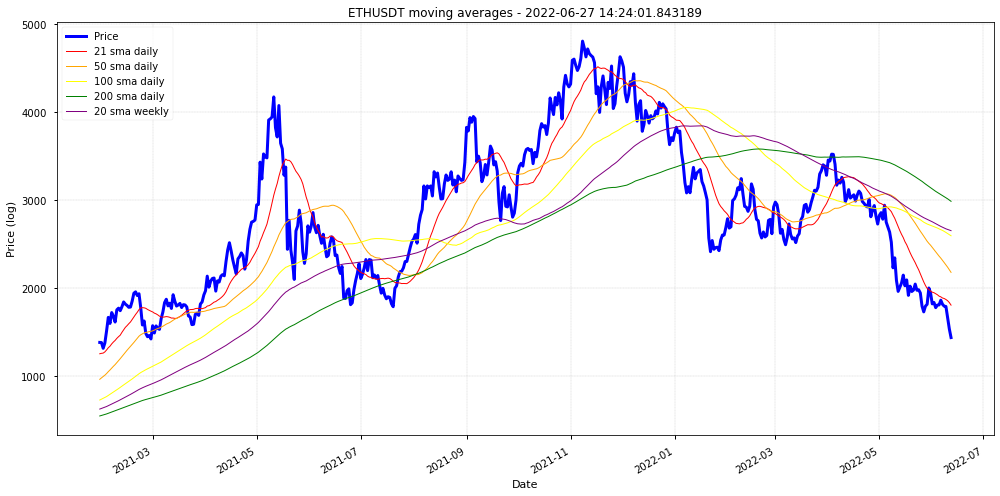

In [15]:
def moving_averages(df):
    """
    A collection of important moving averages in this chart. Be aware that each of them can act as support
    and/or resistance.
    """

    if len(df) > 998:
        
        symbol = "ETHUSDT"
        time_frame = "1 Day"
        ct = str(datetime.now())

        print(f"Creating moving averages plot for {symbol} on {time_frame}...")
        
        # Determine lookback period.
        days = 500

        # Calculate moving averages.
        df['sma21'] = pta.sma(df["close"], length=21)
        df['ema21'] = pta.ema(df["close"], length=21)
        df['sma50'] = pta.sma(df["close"], length=50)
        df['sma100'] = pta.sma(df["close"], length=100)
        df['sma200'] = pta.sma(df["close"], length=200)
        df['wsma20'] = pta.sma(df["close"], length=140)
        # df['wsma200'] = pta.sma(df["close"], length=1400)

        # Plot output to graphs for wiki.
        plt.style.use('seaborn-notebook')
        plt.figure(figsize=(14, 7))
        plt.grid(linestyle='--', linewidth=0.3)

        # df.sort_values(df['Date'], inplace=True)

        dates = df['openTime'].tail(days)
        price = df['close'].tail(days)
        sma21 = df['sma21'].tail(days)
        sma50 = df['sma50'].tail(days)
        sma100 = df['sma100'].tail(days)
        sma200 = df['sma200'].tail(days)
        wsma20 = df['wsma20'].tail(days)
        # wsma200 = df['wsma200'].tail(days)

        # Adding lines.
        plt.plot(dates, price, label='Price', linewidth=3, color='blue')
        plt.plot(dates, sma21, label='21 sma daily', linewidth=1, color='red')
        plt.plot(dates, sma50, label='50 sma daily', linewidth=1, color='orange')
        plt.plot(dates, sma100, label='100 sma daily', linewidth=1, color='yellow')
        plt.plot(dates, sma200, label='200 sma daily', linewidth=1, color='green')
        plt.plot(dates, wsma20, label='20 sma weekly', linewidth=1, color='purple')
        # plt.plot(dates, wsma200, label='200 sma weekly (absolute bottom?)', linewidth=1, color='black')

        # Create log chart.
        # plt.yscale('log')

        plt.gcf().autofmt_xdate()

        plt.title(symbol + ' moving averages - ' + ct)
        plt.xlabel('Date')
        plt.ylabel('Price (log)')
        plt.legend(loc='upper left')
        
        plt.tight_layout()
        plt.show()          # Show plot for visual check. Can be commented out when using in background script.

        # Save plot to external file section:
        # plt.savefig(f'{dir}mdwiki/plots/moving_averages-{symbol}-{time_frame}.png')
        plt.cla()         # Clear plot
        plt.close()       # Close plot
    elif len(df) < 998:
        print(symbol + ' has not enough data to create moving averages chart')

moving_averages(df)

### Supertrend

Creating Supertrend plot for ETHUSDT on 1 Day...


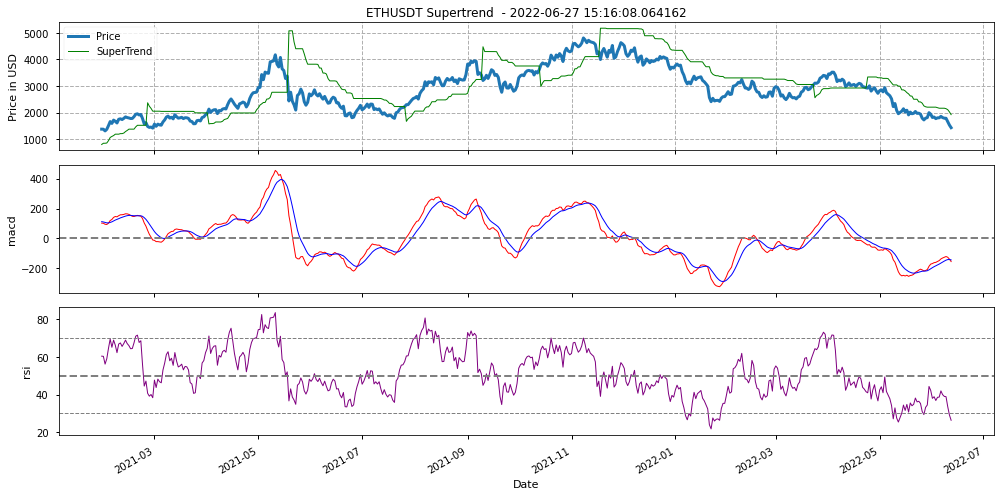

In [32]:
def supertrend(df):
    """
    Plot of supertrend indicator with macd and rsi.
    """
    
    # These variables normally come from outer sources via the function.
    # supertrend(symbol, time_frame, df):
    symbol = "ETHUSDT"
    time_frame = "1 Day"
    ct = str(datetime.now())

    print(f"Creating Supertrend plot for {symbol} on {time_frame}...")

    # Determine lookback period
    days = 500

    # Calculate supertrend indicator
    # supertrend
    length = 5
    multiplier = 3.6
    df["supertrend"] = pta.supertrend(high=df["high"],low=df["low"],close=df["close"],length=length,multiplier=multiplier,)[f"SUPERT_{length}_{multiplier}"]

    # macd
    fast = 12
    slow = 26
    smooth = 9
    df["macd"] = pta.macd(close=df["close"], fast=fast, slow=slow, signal=smooth, offset=None)[f"MACD_{fast}_{slow}_{smooth}"]
    df["macds"] = pta.macd(close=df["close"], fast=fast, slow=slow, signal=smooth, offset=None)[f"MACDs_{fast}_{slow}_{smooth}"]
    # df["macdh"] = pta.macd(close=df["close"], fast=fast, slow=slow, signal=smooth, offset=None)[f"MACDh_{fast}_{slow}_{smooth}"]

    # rsi
    df["rsi"] = pta.rsi(close=df["close"], timeperiod=14)

    # Plot output to graphs for wiki.
    plt.style.use('seaborn-notebook')
    plt.figure(figsize=(14, 7))
    plt.grid(linestyle='--', linewidth=0.3)

    # df.sort_values(df['Date'], inplace=True)

    dates = df['openTime'].tail(days)
    price = df['close'].tail(days)
    supertrend = df["supertrend"].tail(days)
    macd = df['macd'].tail(days)
    macdsignal = df['macds'].tail(days)
    rsi = df["rsi"].tail(days)
    
    # Adding lines to upper plot.
    plt.subplot(3, 1, 1)
    plt.plot(dates, price, label='Price', linewidth=3)
    plt.plot(dates, supertrend, label='SuperTrend', linewidth=1, color='green', alpha=1)

    # Chart markup
    plt.title(symbol + ' Supertrend  - ' + ct)
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(linestyle='--')

    # Adding lines to middle plot.
    plt.subplot(3, 1, 2)
    plt.plot(dates, macd, label='macd', linewidth=1, color='red', alpha=1)
    plt.plot(dates, macdsignal, label='signal', linewidth=1, color='blue', alpha=1)
    plt.axhline(y=0, color='grey', linestyle='--', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('macd')

    # Adding lines to lower plot.
    plt.subplot(3, 1, 3)
    plt.plot(dates, rsi, label='rsi', linewidth=1, color='purple', alpha=1)
    plt.axhline(y=50, color='grey', linestyle='--', linewidth=2)
    plt.axhline(y=30, color='grey', linestyle='--', linewidth=1)
    plt.axhline(y=70, color='grey', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('rsi')

    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()          # Show plot for visual check. Can be commented out when using in background script.

    # Save plot to external file section:
    # plt.savefig(f'{dir}mdwiki/plots/supertrend-{symbol}-{time_frame}.png')
    plt.cla()
    plt.close()
    
supertrend(df)

### Pi cycle top and bottom

Creating PI Cycle plot for ETHUSDT on 1 Day...


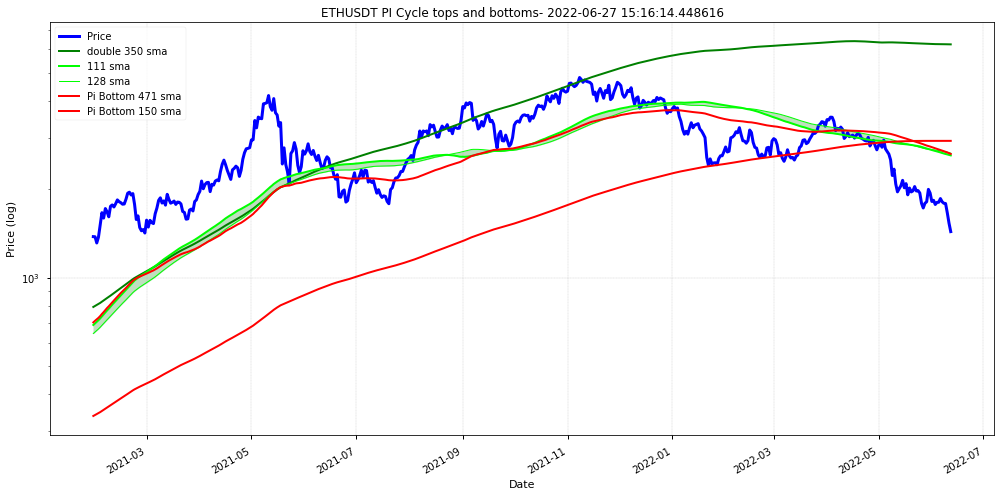

In [33]:
def pi_cycle(df):
    """
    The Pi Cycle Top Indicator has historically been effective in picking out the timing of market cycle highs to within 3 days.
    It uses the 111 day moving average (111DMA) and a newly created multiple of the 350 day moving average, the 350DMA x 2.
    
    Note: The multiple is of the price values of the 350DMA not the number of days.
    
    For the past three market cycles, when the 111DMA moves up and crosses the 350DMA x 2 we see that it coincides with the price 
    of Bitcoin peaking. It is also interesting to note that 350 / 111 is 3.153, which is very close to Pi = 3.142. In fact, it is 
    the closest we can get to Pi when dividing 350 by another whole number.
    It once again demonstrates the cyclical nature of Bitcoin price action over long time frames. Though in this instance it does 
    so with a high degree of accuracy over the past 7 years. 
    
    Bitcoin Price Prediction Using This Tool
    The Pi Cycle Top Indicator forecasts the cycle top of Bitcoin’s market cycles. It attempts to predict the point where Bitcoin 
    price will peak before pulling back. It does this on major high time frames and has picked the absolute tops of Bitcoin’s major 
    price moves throughout most of its history.
    
    How It Can Be Used
    Pi Cycle Top is useful to indicate when the market is very overheated. So overheated that the shorter term moving average, which 
    is the 111 day moving average, has reached a x2 multiple of the 350 day moving average. Historically it has proved advantageous 
    to sell Bitcoin at this time in Bitcoin's price cycles.
    """
    
    # These variables normally come from outer sources via the function.
    # def pi_cycle(symbol, time_frame, df):
    symbol = "ETHUSDT"
    time_frame = "1 Day"
    ct = str(datetime.now())
    
    print(f"Creating PI Cycle plot for {symbol} on {time_frame}...")

    if len(df) > 998:
        # Determine lookback period.
        days = 500

        # Calculate moving averages.
        df['sma350'] = pta.sma(df["close"], length=350)
        df['double_sma350'] = df['sma350'] * 2
        df['sma111'] = pta.sma(df["close"], length=111)
        df['sma128'] = pta.sma(df["close"], length=128)
        df['sma700'] = pta.sma(df["close"], length=700)
        
        # Pi Cycle top
        
        # Pi Cycle bottom
        df['sma471'] = pta.sma(df["close"], length=471)
        df['ema150'] = pta.ema(df["close"], length=150)
        
        # Plot output to graphs for wiki.
        plt.style.use('seaborn-notebook')
        plt.figure(figsize=(14, 7))
        plt.grid(linestyle='--', linewidth=0.3)

        # df.sort_values(df['Date'], inplace=True)

        dates = df['openTime'].tail(days)
        price = df['close'].tail(days)

        # Pi Cycle top
        dsma350 = df['double_sma350'].tail(days)
        sma111 = df['sma111'].tail(days)
        sma128 = df['sma128'].tail(days)
        sma700 = df['sma700'].tail(days)
        
        # Pi Cycle bottom
        sma471 = df['sma471'].tail(days)
        ema150 = df['ema150'].tail(days)

        # Adding lines.
        plt.plot(dates, price, label='Price', linewidth=3, color='blue')
        plt.plot(dates, dsma350, label='double 350 sma', linewidth=2, color='green')
        plt.plot(dates, sma111, label='111 sma', linewidth=2, color='lime')
        plt.plot(dates, sma128, label='128 sma', linewidth=1, color='lime')
        plt.plot(dates, sma471, label='Pi Bottom 471 sma', linewidth=2, color='red')
        plt.plot(dates, ema150, label='Pi Bottom 150 sma', linewidth=2, color='red')
        plt.fill_between(dates, sma111, sma128, color='green', alpha=0.25)

        # Create log chart.
        plt.yscale('log')

        plt.gcf().autofmt_xdate()

        plt.title(symbol + ' PI Cycle tops and bottoms- ' + ct)
        plt.xlabel('Date')
        plt.ylabel('Price (log)')
        plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()          # Show plot for visual check. Can be commented out when using in background script.

        # Save plot to external file section:
        # plt.savefig(f'{dir}mdwiki/plots/pi_cycle-{symbol}-{time_frame}.png')
        plt.cla()         # Clear plot
        plt.close()       # Close plot
    elif len(df) < 998:
        print(symbol + ' has not enough data to create moving averages chart')
        
pi_cycle(df)

### 350 EMA bands

Creating EMA350 & Fibonacci plot for ETHUSDT on 1 Day...


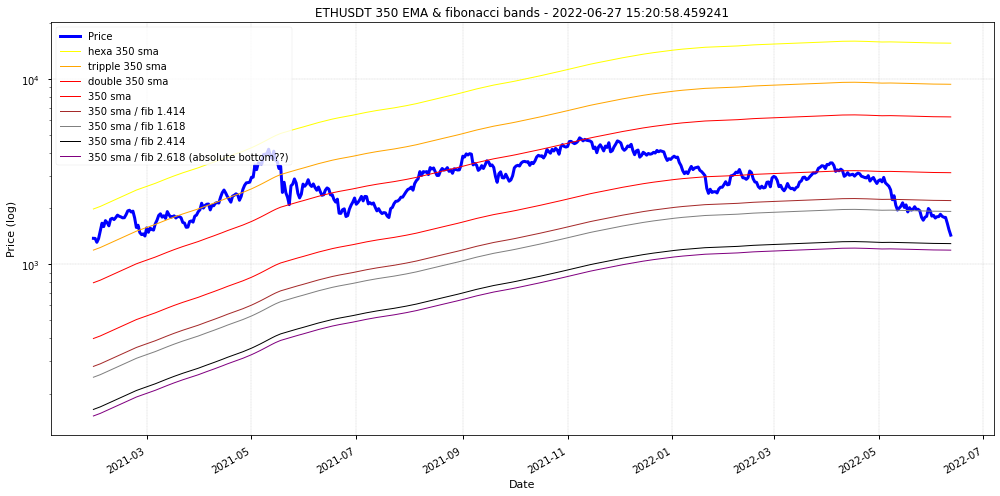

In [34]:
def ema350_bands(df):
    """
    The Pi Cycle Top Indicator has historically been effective in picking out the timing of market cycle highs to within 3 days.
    It uses the 111 day moving average (111DMA) and a newly created multiple of the 350 day moving average, the 350DMA x 2.
    
    Note: The multiple is of the price values of the 350DMA not the number of days.
    
    For the past three market cycles, when the 111DMA moves up and crosses the 350DMA x 2 we see that it coincides with the price 
    of Bitcoin peaking. It is also interesting to note that 350 / 111 is 3.153, which is very close to Pi = 3.142. In fact, it is 
    the closest we can get to Pi when dividing 350 by another whole number.
    It once again demonstrates the cyclical nature of Bitcoin price action over long time frames. Though in this instance it does 
    so with a high degree of accuracy over the past 7 years. 
    
    Bitcoin Price Prediction Using This Tool
    The Pi Cycle Top Indicator forecasts the cycle top of Bitcoin’s market cycles. It attempts to predict the point where Bitcoin 
    price will peak before pulling back. It does this on major high time frames and has picked the absolute tops of Bitcoin’s major 
    price moves throughout most of its history.
    
    How It Can Be Used
    Pi Cycle Top is useful to indicate when the market is very overheated. So overheated that the shorter term moving average, which 
    is the 111 day moving average, has reached a x2 multiple of the 350 day moving average. Historically it has proved advantageous 
    to sell Bitcoin at this time in Bitcoin's price cycles.
    """
    
    # These variables normally come from outer sources via the function.
    # def pi_cycle(symbol, time_frame, df):
    symbol = "ETHUSDT"
    time_frame = "1 Day"
    ct = str(datetime.now())
    
    print(f"Creating EMA350 & Fibonacci plot for {symbol} on {time_frame}...")

    if len(df) > 998:
        # Determine lookback period.
        days = 500

        # Calculate moving averages.
        df['sma350'] = pta.sma(df["close"], length=350)
        df['double_sma350'] = df['sma350'] * 2
        df['tripple_sma350'] = df['sma350'] * 3
        df['hexa_sma350'] = df['sma350'] * 5
        df['fib1414_sma350'] = df['sma350'] / 1.414
        df['fib1618_sma350'] = df['sma350'] / 1.618
        df['fib2_sma350'] = df['sma350'] / 2
        df['fib2414_sma350'] = df['sma350'] / 2.414
        df['fib2618_sma350'] = df['sma350'] / 2.618
        df['sma111'] = pta.sma(df["close"], length=111)
        df['sma128'] = pta.sma(df["close"], length=128)
        df['sma700'] = pta.sma(df["close"], length=700)
        
        # Pi Cycle top
        
        # Pi Cycle bottom
        df['sma471'] = pta.sma(df["close"], length=471)
        df['ema150'] = pta.ema(df["close"], length=150)
        
        # Plot output to graphs for wiki.
        plt.style.use('seaborn-notebook')
        plt.figure(figsize=(14, 7))
        plt.grid(linestyle='--', linewidth=0.3)

        # df.sort_values(df['Date'], inplace=True)

        dates = df['openTime'].tail(days)
        price = df['close'].tail(days)
        sma350 = df['sma350'].tail(days)
        dsma350 = df['double_sma350'].tail(days)
        tsma350 = df['tripple_sma350'].tail(days)
        hsma350 = df['hexa_sma350'].tail(days)
        fib1414 = df['fib1414_sma350'].tail(days)
        fib1618 = df['fib1618_sma350'].tail(days)
        fib2414 = df['fib2414_sma350'].tail(days)
        fib2618 = df['fib2618_sma350'].tail(days)
        
        # Pi Cycle bottom
        sma471 = df['sma471'].tail(days)
        ema150 = df['ema150'].tail(days)

        # Adding lines.
        plt.plot(dates, price, label='Price', linewidth=3, color='blue')
        plt.plot(dates, hsma350, label='hexa 350 sma', linewidth=1, color='yellow')
        plt.plot(dates, tsma350, label='tripple 350 sma', linewidth=1, color='orange')
        plt.plot(dates, dsma350, label='double 350 sma', linewidth=1, color='red')
        plt.plot(dates, sma350, label='350 sma', linewidth=1, color='red')
        plt.plot(dates, fib1414, label='350 sma / fib 1.414', linewidth=1, color='brown')
        plt.plot(dates, fib1618, label='350 sma / fib 1.618', linewidth=1, color='grey')
        plt.plot(dates, fib2414, label='350 sma / fib 2.414', linewidth=1, color='black')
        plt.plot(dates, fib2618, label='350 sma / fib 2.618 (absolute bottom??)', linewidth=1, color='purple')
        
        # Create log chart.
        plt.yscale('log')

        plt.gcf().autofmt_xdate()

        plt.title(symbol + ' 350 EMA & fibonacci bands - ' + ct)
        plt.xlabel('Date')
        plt.ylabel('Price (log)')
        plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()          # Show plot for visual check. Can be commented out when using in background script.

        # Save plot to external file section:
        # plt.savefig(f'{dir}mdwiki/plots/pi_cycle-{symbol}-{time_frame}.png')
        plt.cla()         # Clear plot
        plt.close()       # Close plot
    elif len(df) < 998:
        print(symbol + ' has not enough data to create moving averages chart')
        
ema350_bands(df)